In [6]:
import pyeeg
from easygui import *
import pyxdf
import PyQt5
import mne
import numpy as np
from os import listdir
from os.path import isfile, join
import pandas as pd
import pathlib
import mne
import matplotlib
import matplotlib.pyplot as plt
from joblib import dump, load
import seaborn as sns
from joblib import dump
# For interactive plots
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'qt')
from subfunctions import read_xdf, add_annot

In [2]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from mne.decoding import (SlidingEstimator, GeneralizingEstimator, Scaler,
                          cross_val_multiscore, LinearModel, get_coef,
                          Vectorizer, CSP)


# Decoding

### Load Preproccesed data 

In [9]:
current_path = pathlib.Path().absolute()  
data_fname = current_path /'Data'/'processed data'/'Omri_Recording_001_ep_rejected.xdf'
epochs = mne.read_epochs(data_fname)

Reading /Users/ordez/Documents/BCI_ALS/Data/processed data/Omri_Recording_001_ep_rejected.xdf ...
    Found the data of interest:
        t =    -200.00 ...     496.00 ms
        0 CTF compensation matrices available
Not setting metadata
277 matching events found
No baseline correction applied
0 projection items activated


/var/folders/10/8b2yhzhd2c360q83nm9l57740000gn/T/ipykernel_1578/428782914.py:3: RuntimeWarning: This filename (/Users/ordez/Documents/BCI_ALS/Data/processed data/Omri_Recording_001_ep_rejected.xdf) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(data_fname)


### Xdon

In [4]:
#epochs.crop(tmin=0.25) # Remove baseline period

X = epochs.get_data()  # MEG signals: n_epochs, n_meg_channels, n_times
# Remove baslineperiod
baseline_duration = -0.2
onset_sample = int(np.absolute(baseline_duration) * 125)
X = X[:,:,onset_sample::]

y = epochs.events[:, 2]  # target: auditory left vs visual left
y = y-1 # 0's and 1's instead of 1's and 2's


In [8]:
# Some standard pythonic imports
import warnings
warnings.filterwarnings('ignore')
import os,numpy as np,pandas as pd
from collections import OrderedDict
import seaborn as sns
from matplotlib import pyplot as plt

# MNE functions
from mne import Epochs,find_events
from mne.decoding import Vectorizer


# Scikit-learn and Pyriemann ML functionalities
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit
from pyriemann.estimation import ERPCovariances, XdawnCovariances, Xdawn
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import MDM

clfs = OrderedDict()
clfs['Vect + LR'] = make_pipeline(Vectorizer(), StandardScaler(), LogisticRegression())
clfs['Vect + RegLDA'] = make_pipeline(Vectorizer(), LDA(shrinkage='auto', solver='eigen'))
clfs['Xdawn + RegLDA'] = make_pipeline(Xdawn(2, classes=[1]), Vectorizer(), LDA(shrinkage='auto', solver='eigen'))

clfs['XdawnCov + TS'] = make_pipeline(XdawnCovariances(estimator='oas'), TangentSpace(), LogisticRegression())
clfs['XdawnCov + MDM'] = make_pipeline(XdawnCovariances(estimator='oas'), MDM())


clfs['ERPCov + TS'] = make_pipeline(ERPCovariances(), TangentSpace(), LogisticRegression())
clfs['ERPCov + MDM'] = make_pipeline(ERPCovariances(), MDM())


# format data
epochs.pick_types(eeg=True)
X = epochs.get_data() * 1e6
baseline_duration = -0.2
onset_sample = int(np.absolute(baseline_duration) * 125)
X = X[:,:,onset_sample::]

times = epochs.times
y = epochs.events[:, -1]
y = y-1

# define cross validation
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.25, random_state=42)

# run cross validation for each pipeline
auc = []
methods = []
for m in clfs:
    res = cross_val_score(clfs[m], X, y==1, scoring='roc_auc', cv=cv, n_jobs=-1)
    auc.extend(res)
    methods.extend([m]*len(res))

results = pd.DataFrame(data=auc, columns=['AUC'])
results['Method'] = methods

plt.figure(figsize=[8,4])
sns.barplot(data=results, x='AUC', y='Method')
plt.xlim(0.2, 0.85)
sns.despine()



/Users/ordez/opt/anaconda3/envs/BCI_ALS/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ordez/opt/anaconda3/envs/BCI_ALS/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

## Lets fit the model to the data and dave it

### First, Choose the best model to save

In [11]:
pipe = clfs['Vect + LR'] 

NameError: name 'clfs' is not defined

In [46]:
pipe.fit(X,y)

input_shape = X.shape
ch_names = epochs.ch_names

class model:
    clsf = '' 
    input_shape = ''
    ch_names = ''


model = model
model.clsf = pipe
model.input_shape = input_shape
model.ch_names = ch_names


dump(model, 'model_omri_1.joblib')


model = load('model_omri_1.joblib') 

In [50]:
def online_prediction(Data,input_shape,model):
    assert len(Data.shape) == 3, 'X is not 3D'
    assert Data.shape[1] == input_shape[1] , 'Number of electrodes differs'
    assert Data.shape[2] >= input_shape[2] , 'Data is too short'
    Data = Data[:,:,0:input_shape[2]]
    pred_y = model.predict(Data)
    return pred_y

real = X[0:10,:,:]
clfs['Vect + LR'].predict(real)

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0], dtype=int32)

In [7]:
online_prediction(X[:,:,0:63],input_shape)

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0], dtype=int32)

### Pyeeg

In [39]:
def HFD(data):
    return pyeeg.hfd(data,5)

In [40]:
# Make sure to split train and test before feature exploration 

In [43]:
df_feat = pd.DataFrame() 
for j,ch in enumerate(epochs.ch_names):
        df_feat[f'Max_{ch}'] = None
l = []

for i,epoch in enumerate(X):
    max_amp = []
    l.append( HFD(np.sum(epoch,axis=0)))
    for j,ch in enumerate(epochs.ch_names):
        max_amp.append(np.max(epoch[j,:]))
    df_feat.loc[len(df_feat)] = max_amp

    
    

In [44]:
   
df_feat['HFD'] = l
df_feat['Target'] = y
df_feat["Target"] = df_feat["Target"].astype("category")

sns.violinplot(data=df_feat, x = 'Max_CP1',y = 'Target',inner= 'stick')

<AxesSubplot:xlabel='Max_CP1', ylabel='Target'>

### Classic logistig regression

In [45]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

df_feat = df_feat.drop(columns= 'Target' )

logisticRegr = LogisticRegression(class_weight='auto')

X_train, X_test, y_train, y_test = train_test_split(df_feat, y, test_size=0.3, random_state=20)

logisticRegr.fit(X_train, y_train)

y_pred = logisticRegr.predict(X_test)

score = logisticRegr.score(X_test, y_test)
print(score)

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix


weight_vector = list(logisticRegr.coef_[0])

dist = np.dot(X_train, weight_vector)
y_dist = dist*[-1 if x==0 else 1 for x in list(y_train)]

0.7857142857142857


In [49]:
class_names=['Standard','Target'] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Text(0.5,257.44,'Predicted label');

NameError: name 'Text' is not defined

### MNE MVPA

In [149]:
#epochs.crop(tmin=0.25) # Remove baseline period

X = epochs.get_data()  # EEG signals: n_epochs, n_meg_channels, n_times
y = epochs.events[:, 2]  # target: auditory left vs visual left
y = y-1 # 0's and 1's instead of 1's and 2's


In [49]:
# Uses all EEG sensors and time points as separate classification
# features, so the resulting filters used are spatio-temporal
clf = make_pipeline(
    Scaler(epochs.info),
    Vectorizer(),
    LogisticRegression(solver='liblinear')  # liblinear is faster than lbfgs
)

scores = cross_val_multiscore(clf, X, y, cv=4, n_jobs=None)

# Mean scores across cross-validation splits
score = np.mean(scores, axis=0)
print('Spatio-temporal: %0.1f%%' % (100 * score,))


Spatio-temporal: 66.1%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s finished


In [125]:
# Uses all EEG sensors and time points as separate classification
# features, so the resulting filters used are spatio-temporal
clf = make_pipeline(
    
    Vectorizer(),
    LogisticRegression(solver='liblinear')  # liblinear is faster than lbfgs
)

scores = cross_val_multiscore(clf, X, y, cv=4, n_jobs=None)

# Mean scores across cross-validation splits
score = np.mean(scores, axis=0)
print('Spatio-temporal: %0.1f%%' % (100 * score,))


clf.fit(X,y)
real = X[0:2,:,:]
clf.predict(real)
#clf[0].fit(real)

Spatio-temporal: 79.4%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished


array([0, 0], dtype=int32)

In [91]:
from sklearn import set_config
set_config(display='diagram')
# with display='diagram', simply use display() to see the diagram
display(clf)
# if desired, set display back to the default
set_config(display='text')

Pipeline(steps=[('vectorizer',
                 <mne.decoding.transformer.Vectorizer object at 0x7f82c9ae3730>),
                ('logisticregression', LogisticRegression(solver='liblinear'))])

### Xdon

In [ ]:
clfs['Vect + LR'].fit()

### We can also use Scaler manually

In [35]:
X_scaled = Scaler(X)
X_scaled_data = X_scaled.info

## Decode fedality accros time

In [28]:
# Uses all MEG sensors and time points as separate classification
# features, so the resulting filters used are spatio-temporal
clf = make_pipeline(
    Scaler(epochs.info),
    Vectorizer(),
    LogisticRegression(solver='liblinear')  # liblinear is faster than lbfgs
)

time_decod = SlidingEstimator(
    clf, n_jobs=None, scoring='roc_auc', verbose=True)
# here we use cv=3 just for speed
scores = cross_val_multiscore(time_decod, X, y, cv=3, n_jobs=None)


# Mean scores across cross-validation splits
scores = np.mean(scores, axis=0)

# Plot
fig, ax = plt.subplots()
ax.plot(epochs.times, scores, label='score')
ax.axhline(.5, color='k', linestyle='--', label='chance')
ax.set_xlabel('Times')
ax.set_ylabel('AUC')  # Area Under the Curve
ax.legend()
ax.axvline(.0, color='k', linestyle='-')
ax.set_title('Sensor space decoding')
plt.show()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/ordez/opt/anaconda3/envs/BCI_ALS/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| Fitting SlidingEstimator : 63/63 [00:00<00:00,  363.29it/s]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
100%|██████████| Fitting SlidingEstimator : 63/63 [00:00<00:00,  176.68it/s]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]

Using data from preloaded Raw for 24 events and 101 original time points ...
Not setting metadata
24 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


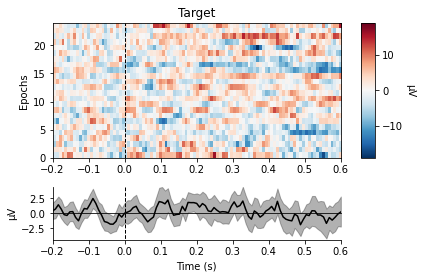

Using data from preloaded Raw for 96 events and 101 original time points ...
Not setting metadata
96 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


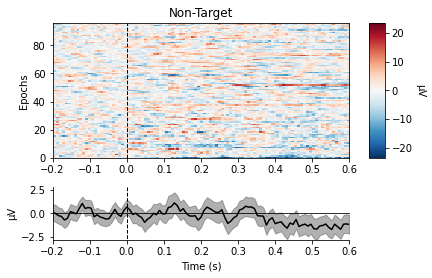

[<Figure size 432x288 with 3 Axes>]

In [19]:
get_ipython().run_line_magic('matplotlib', 'inline')

epochs['Target Trial'].plot_image(picks='eeg', combine='mean',title="Target")
epochs['Standard Trial'].plot_image(picks='eeg', combine='mean',title="Non-Target")


## Plot evoked data

No projector specified for this dataset. Please consider the method self.add_proj.


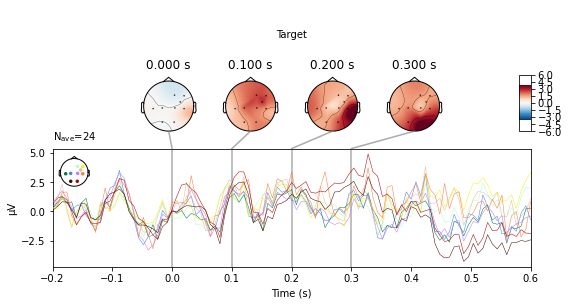

No projector specified for this dataset. Please consider the method self.add_proj.


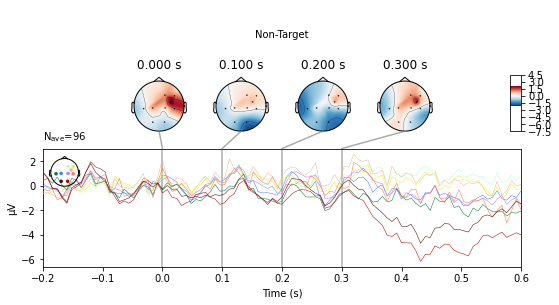

In [20]:
odd_evoked =  epochs['Target Trial'].average()
stand_evoked =  epochs['Standard Trial'].average()

par_picks = ['CP1','CP2'] # to plot only parietal



odd_evoked.plot_joint(picks='eeg',times=[0,0.1,0.2,0.3],title = 'Target')
stand_evoked.plot_joint(picks='eeg',times=[0,0.1,0.2,0.3],title = 'Non-Target')

plt.show()

## Lets compare the two ERPs

In [63]:
# For interactive plot:
get_ipython().run_line_magic('matplotlib', 'qt')

fig, ax = plt.subplots(4,figsize=(15, 20))


P300_window = [0.25,0.4]
par_picks = ['CP1','CP2'] # to plot only parietal


odd_evoked.plot(gfp=True,
    highlight=P300_window,axes=ax[0],titles='Target')

stand_evoked.plot(gfp=True,
    highlight=P300_window,axes=ax[1],titles='Non Target')

evokeds = dict(Non_Target=list(epochs['Standard Trial'].iter_evoked()),
               Target=list(epochs['Target Trial'].iter_evoked()))

mne.viz.plot_compare_evokeds(dict(Non_Target=stand_evoked, Target=odd_evoked),combine='mean',show_sensors= True,vlines= [0.3] ,axes=ax[2])

mne.viz.plot_compare_evokeds(evokeds, combine='mean',axes=ax[3])


plt.tight_layout()
#plt.show()

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


/var/folders/10/8b2yhzhd2c360q83nm9l57740000gn/T/ipykernel_85729/3830931353.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


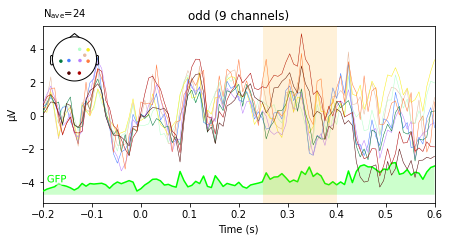

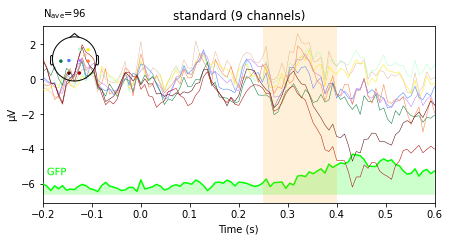

combining channels using "mean"
combining channels using "mean"


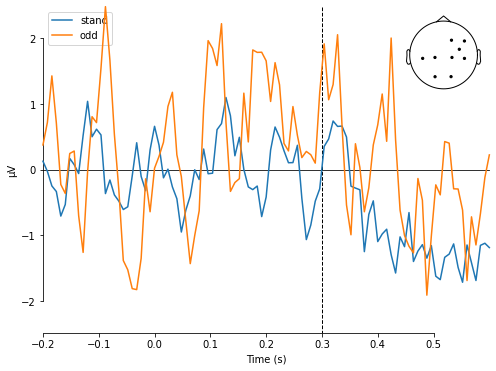

combining channels using "mean"
combining channels using "mean"


<Figure size 432x288 with 0 Axes>

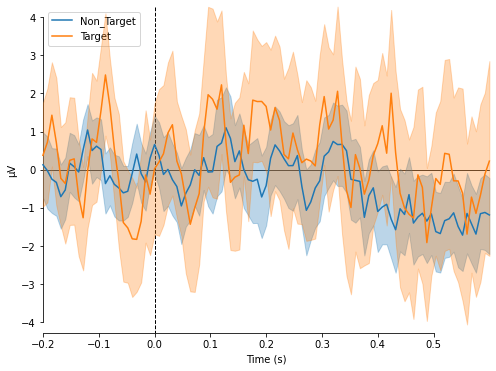

In [48]:
# Regular plots

get_ipython().run_line_magic('matplotlib', 'inline')


P300_window = [0.25,0.4]
par_picks = ['CP1','CP2'] # to plot only parietal


odd_evoked.plot(gfp=True,
    highlight=P300_window,titles='odd')

stand_evoked.plot(gfp=True,
    highlight=P300_window,titles='standard')

mne.viz.plot_compare_evokeds(dict(stand=stand_evoked, odd=odd_evoked),combine='mean',show_sensors= True,vlines= [0.3])


plt.tight_layout()


# We can also plot the CI of each ERP calss

evokeds = dict(Non_Target=list(epochs['Standard Trial'].iter_evoked()),
               Target=list(epochs['Target Trial'].iter_evoked()))
mne.viz.plot_compare_evokeds(evokeds, combine='mean')

get_ipython().run_line_magic('matplotlib', 'qt')

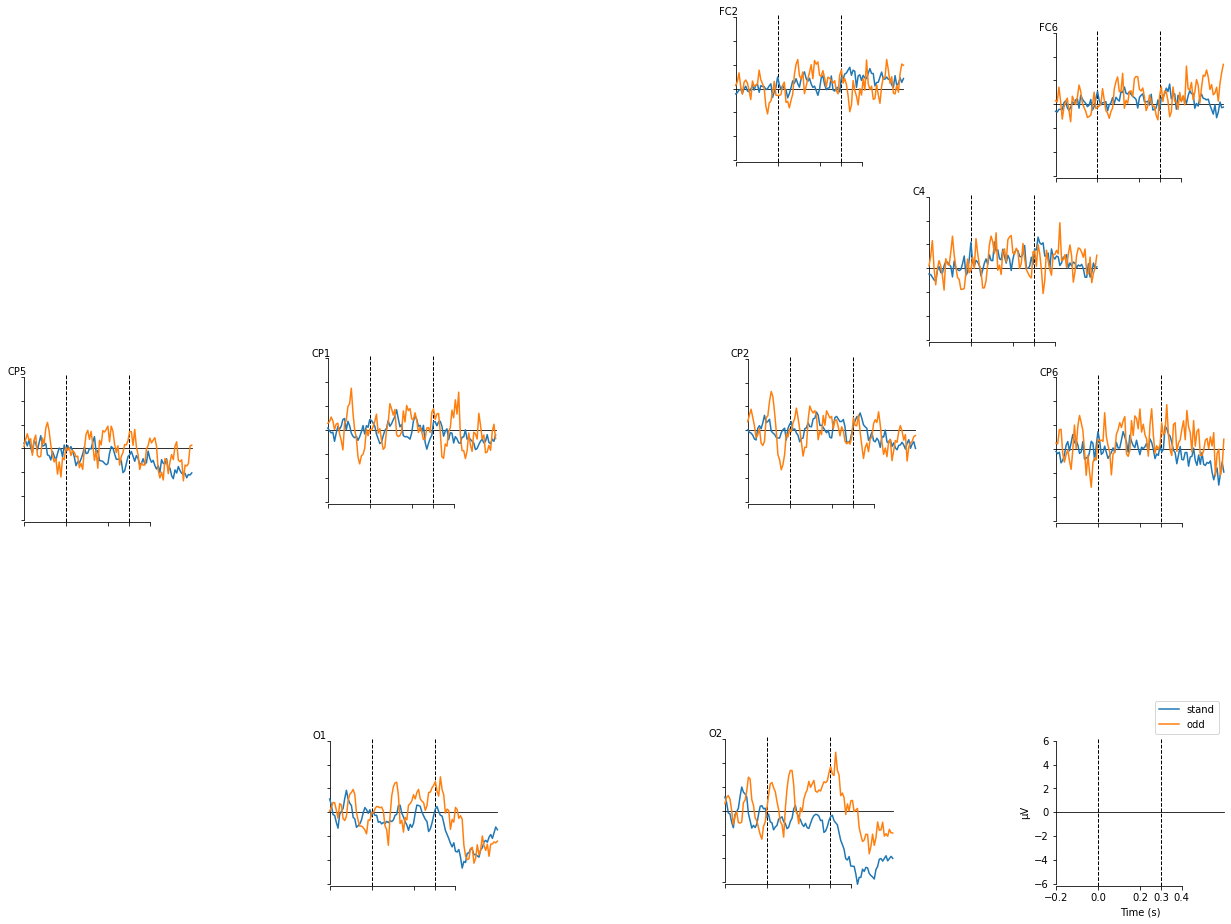

[<Figure size 1296x1008 with 10 Axes>]

In [52]:
# Each electrode indvidually 
get_ipython().run_line_magic('matplotlib', 'inline')
mne.viz.plot_compare_evokeds(dict(stand=stand_evoked, odd=odd_evoked),axes='topo',vlines=[0,0.3])

## ICA

In [53]:
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,
                               corrmap)

ica = ICA(n_components=raw.info['nchan'], max_iter='auto', random_state=97)
ica.fit(raw)
ica

Fitting ICA to data using 9 channels (please be patient, this may take a while)
Selecting by number: 9 components
Fitting ICA took 0.3s.


<ICA | raw data decomposition, method: fastica (fit in 32 iterations on 31405 samples), 9 ICA components (9 PCA components available), channel types: eeg, no sources marked for exclusion>

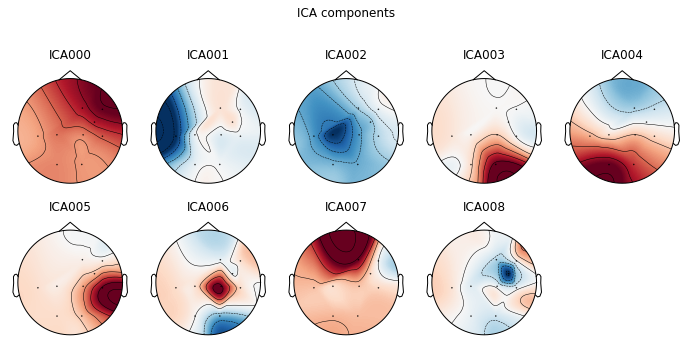

[<MNEFigure size 702x357.12 with 9 Axes>]

In [54]:
ica.plot_components()

Creating RawArray with float64 data, n_channels=9, n_times=31405
    Range : 0 ... 31404 =      0.000 ...   251.232 secs
Ready.


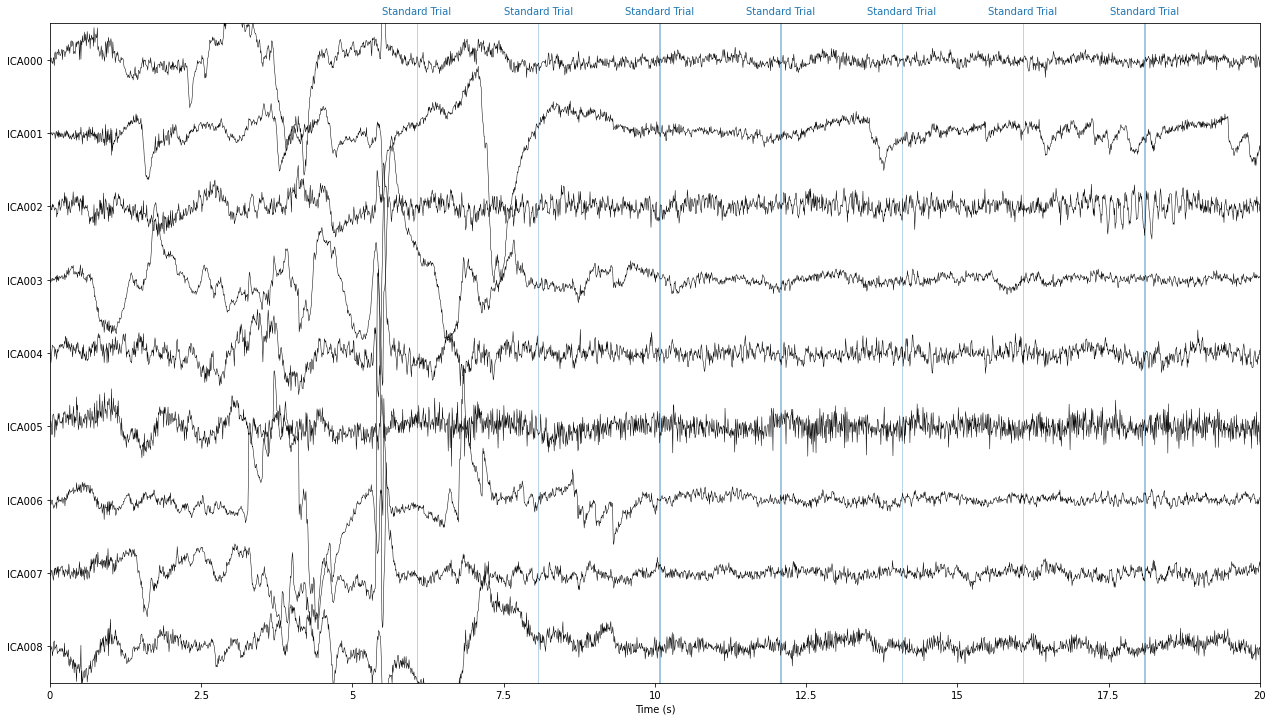

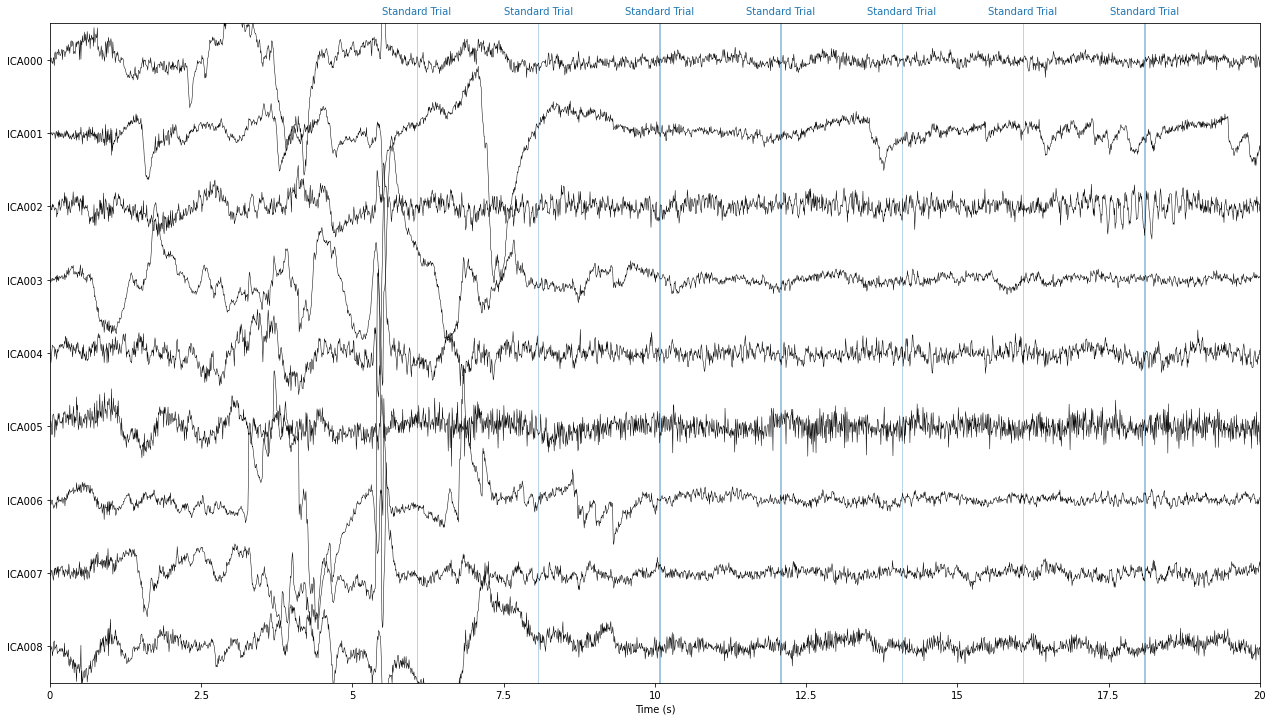

In [55]:
ica.plot_sources(raw, show_scrollbars=False)

Applying ICA to Raw instance
    Transforming to ICA space (9 components)
    Zeroing out 1 ICA component
    Projecting back using 9 PCA components


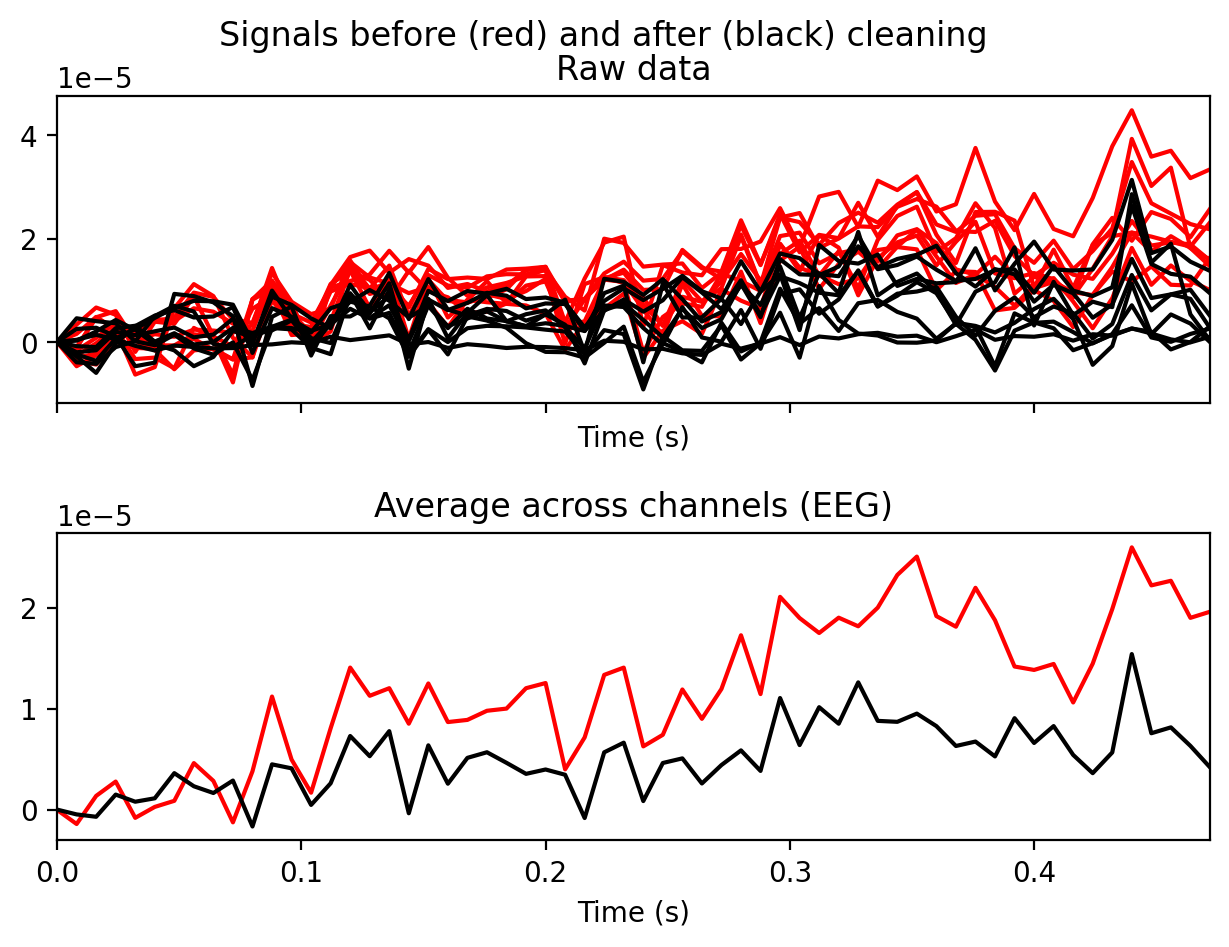

In [89]:
ica.plot_overlay(raw, exclude=[0], picks='eeg',start=0,stop=60)

# The first element looks like drift

Applying ICA to Raw instance
    Transforming to ICA space (9 components)
    Zeroing out 3 ICA components
    Projecting back using 9 PCA components


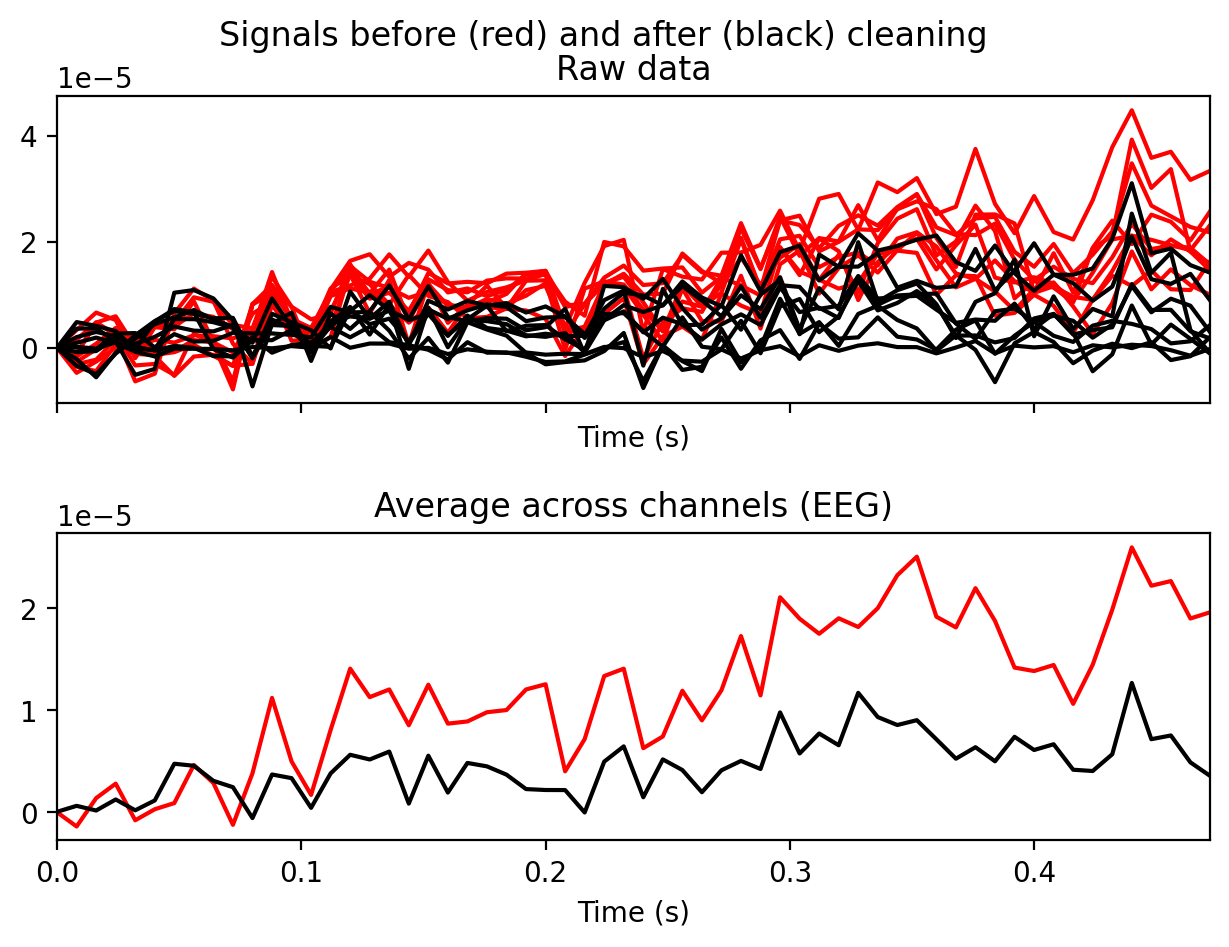

In [97]:
# None will show the selected componenets 
ica.plot_overlay(raw, exclude=[7], picks='eeg',start=0,stop=60)


    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
125 matching events found
No baseline correction applied
0 projection items activated


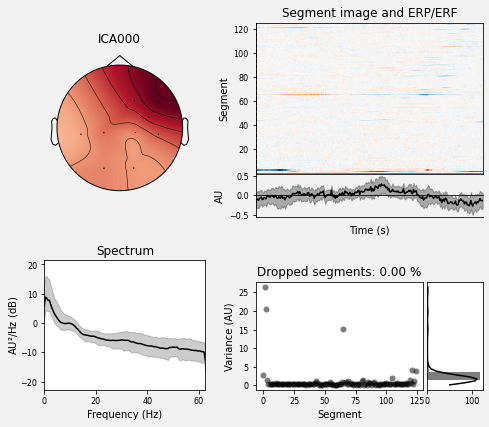

[<Figure size 504x432 with 6 Axes>]

In [62]:
ica.plot_properties(raw, picks=[0])

## Finally, lets applay the ICA and reconstruct the sensor data 

In [98]:
reconst_raw = raw.copy()
ica.apply(reconst_raw)

Applying ICA to Raw instance
    Transforming to ICA space (9 components)
    Zeroing out 3 ICA components
    Projecting back using 9 PCA components


<RawArray | 9 x 31405 (251.2 s), ~2.2 MB, data loaded>

## Lets look at the differences

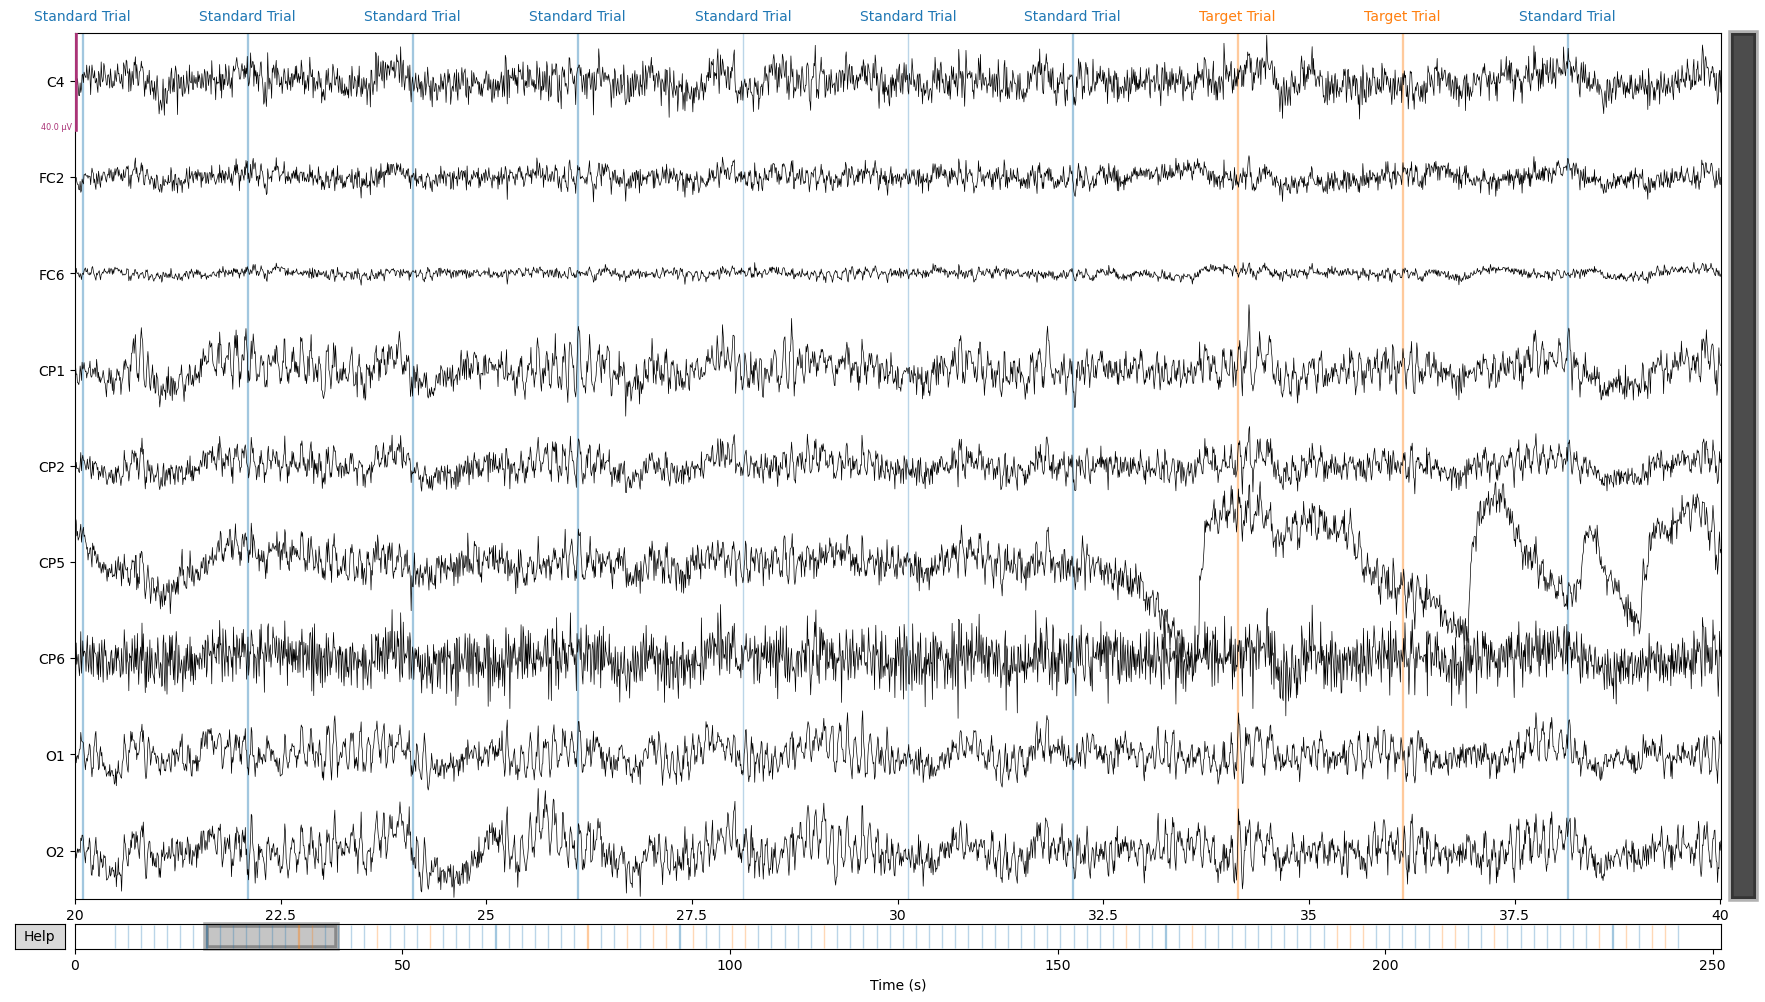

In [104]:
reconst_raw.plot(duration=20,start=20,show= False)

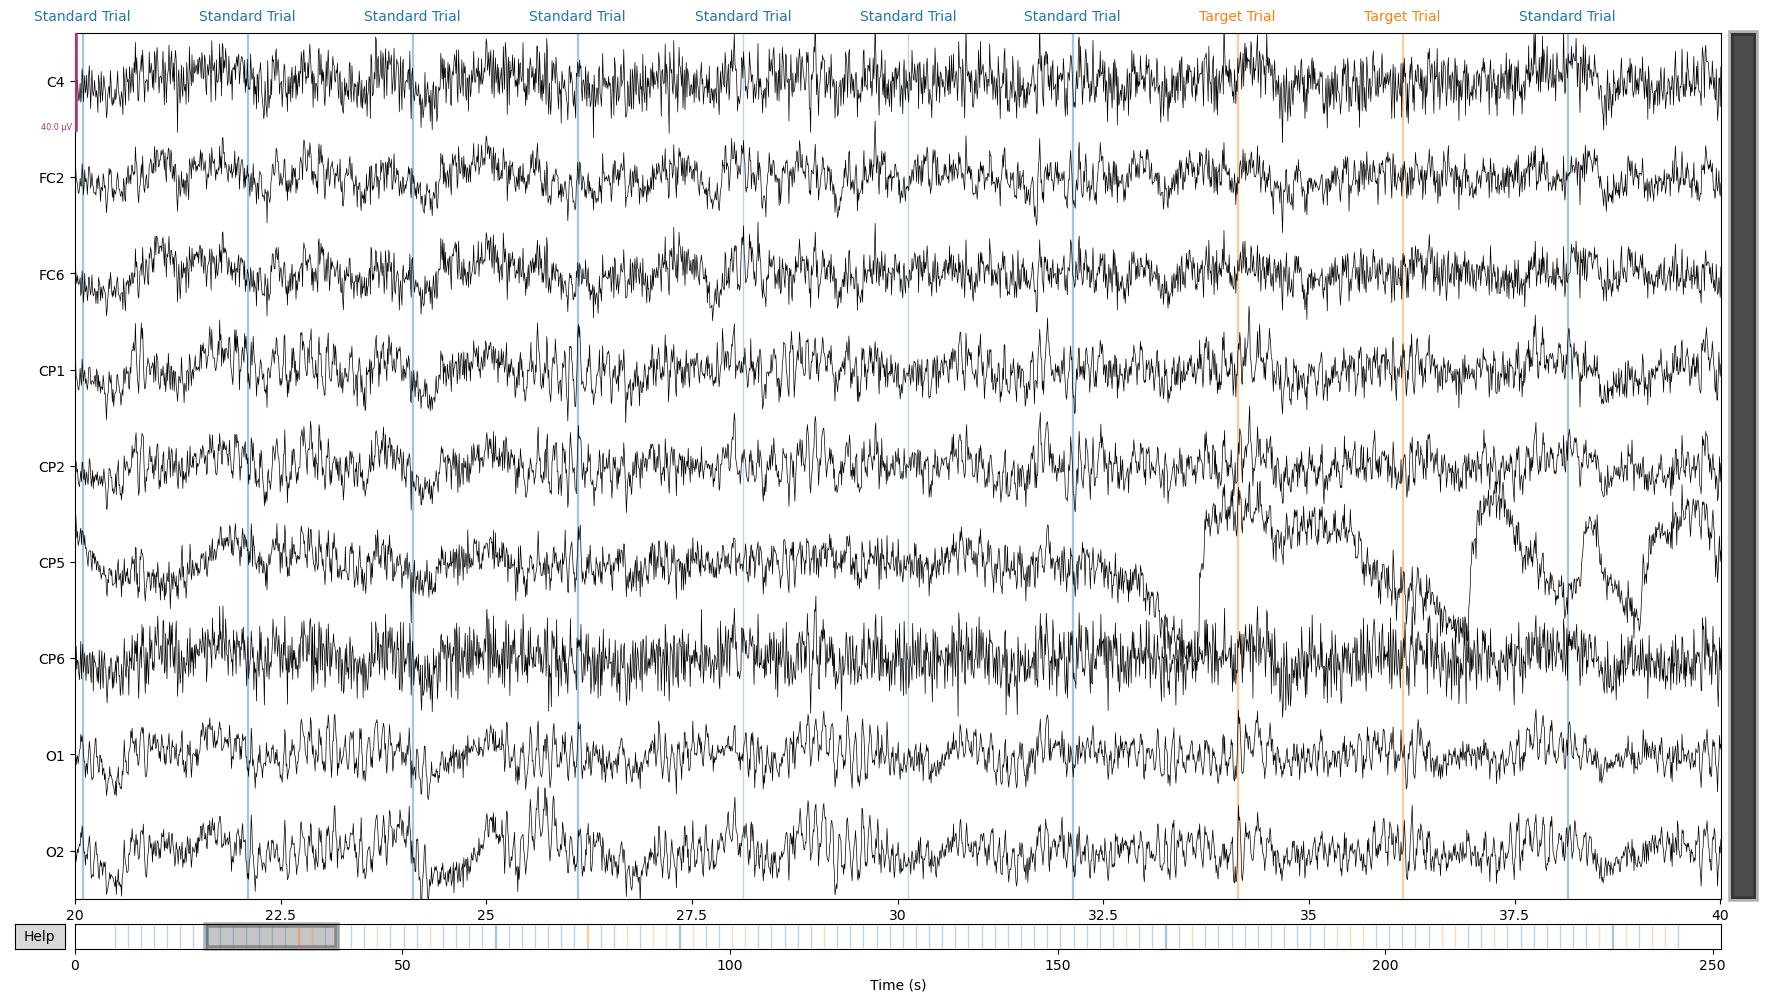

In [107]:
original_raw.plot(duration=20,start=20,show= False)
